## Portfolio: US Counties Poverty Rate Prediction ##
This is data science portfolio based on real dataset to predict poverty rate across the United States at the country level using socio-economic indicators. The dataset was compiled from wide range of sources and publicly made available by United States Department of Agriculture Economic Research Service (USDA ERS). It can be found here https://datasciencecapstone.org/competitions/3/county-poverty/page/10/.

**Goal:**
To make accurate predictions on US counties' poverty rate with minimum root-mean-squared-errors (RMSEs).

**Results:** 
Using feature selection techniques (L1, L2, Feature Importance), best combination of features were
selected to train each model. the XGBoost regressor was the best model with **RMSE: 2.67** on a test set.

**Risks:** With visual inspection from residual and quantile plots, there were some errors for making accurate predictions. Especially, from lower and upper range of poverty rate of counties were deviated a lot from predictions.

**Mitigation:** 
Review these identified errors and outliers with subject matter experts before making any implementation or policy changes to improve poverty rates across US counties.

**Future Work:**
1. Model improvements: feasibility of testing other ensemble models, stacking and neural network.
2. Data collection/refinement: integrate with other financial and job market-related data sources 
    * Household income by counties 
    * Job market trends by counties
    * KPIs related to accessibility for basic needs (i.e., food, housing, etc.)

**Recommendation for clients:** 
1. *Support economic development plan for nonmetro counties.* A lot of nonmetro counties with population less than 2,000 characterized by no specialized industries and government fund dependent were in higher poverty rates. Thus, it is important for federal and state government agencies to help them establish their own specialized industries (i.e., tourism, agricultural and etc.) for resolving higher poverty rates.
2. *Maintain good transportation infrastructure and urban planning for nonmetro counties.* Combined effects of large population size and adjacency to metro area showed lower poverty rates. Usually, the bigger and well developed urban counties tend to have huge pool of job openings. Thus, lower poverty rates were observed in comparison to counties located far from metro area.

## Part 1 - DEFINE ##

**Problem Statement:** 
In United States, being poverty is defined as having an income below a federally defined poverty threshold. This represents US federal government's estimation of how many families are below in which their income levels do not meet any basic needs (i.e., food, shelter, clothing and other essential goods). Thus, our goal is to make predictions on poverty rates by counties within US in order to make recommendations for federal government agencies. This will help them to initiate and implement policies/support the families below officially defined poverty thresholds.
The US poverty rate dataset contains 33 features in total. There are 30 numerical and 3 categorical features to predict one target variable (i.e., poverty_rate). There are 4 different kinds of information are available from this dataset which includes county's urbanization degree (development level), economic indicators, health indicators and demographic indicators. 

**Stakeholders:** 
US federal policymakers, counties' representatives and other Not-For-Profit (NFP) organizations.

**Goal:**
To make accurate predictions on US counties' poverty rate with minimum root-mean-squared-errors (RMSEs).

In [1]:
# Import all libraries #
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import statsmodels.api as sm
import scipy.stats as sp
import sklearn.metrics as skm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.utils import shuffle
from sklearn.preprocessing import Imputer, StandardScaler, PolynomialFeatures 
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Authorship:
__author__ = 'Taesun Yoo'
__email__ = 'yoots1988@gmail.com'

## Part 2 - DISCOVERY ##

In [2]:
# --- 2. Write Out List of Functions --- #
def load_file(file):
    '''load input CSVs as a dataframe '''
    return pd.read_csv(file)

def join_data(df1, df2, key=None, left_index=False, right_index=False):
    '''performs inner join to return records exist in both dataframes'''
    return pd.merge(df1, df2, how='inner', on=key, left_index=left_index,
                    right_index=right_index)

def clean_data(raw_df):
    '''remove rows that contain invalid data or duplicate IDs'''
    clean_df = raw_df.drop_duplicates(subset='row_id')
#    clean_df = clean_df[clean_df['health__homicides_per_100k'] > 0]
    return clean_df

def eda_missing_data(df):
    '''computes missing % on each column of a dataframe'''
    missing_df = df.isnull().sum()
    missing_df = pd.DataFrame(missing_df, columns=['count'])
    missing_df['pct'] = missing_df['count']/len(missing_df)
    missing_df = missing_df.sort_values(by='pct', ascending=False)
    return missing_df

def eda_summary_stat_num(df):
    '''shows summary statistics on numerical variables'''
    df_stat = df.describe().T
    df_stat = df_stat[['count', 'min', 'max', 'mean', 'std', '25%', '50%', '75%']]
    df_stat = df_stat.sort_values(by='count', ascending=True)
    df_stat = pd.DataFrame(df_stat)
    return df_stat

def eda_summary_stat_cat(df):
    '''shows summary statistics on categorical variables'''    
    df_stat = df.describe(include='O').T
    df_stat = pd.DataFrame(df_stat)
    return df_stat

# Functon: Screening Outliers using IQR
def outliers_iqr(df_stat):
    '''compute outliers based on IQR'''
    df_stat['IQR'] = df_stat['75%'] - df_stat['25%']
    df_stat['UB'] = df_stat['75%'] + 1.5*df_stat['IQR']
    df_stat['LB'] = df_stat['25%'] - 1.5*df_stat['IQR']
    df_outliers = df_stat[['LB', 'min', 'UB', 'max']]
    return df_outliers    

def dq_invalid_list(df, col_name):
    '''compute indexes for rows with negative values on a selected feature'''
    idx_list = list(df.loc[df[col_name]<0].index)
    return idx_list

def dq_column_list(df, col_name):
    '''computes a column list for missing value more than 50%'''
    col_list = list(df[df[col_name]>50].index)
    return col_list

def drop_row_by_index(df, idx_list):
    '''drop invalid rows from a dataframe'''
    df_row_drop = df.drop(df.index[idx_list])
    return df_row_drop

def drop_column_by_index(df, col_list):
    '''drop a specified column from a dataframe'''
    df_column_drop = df.drop(col_list, axis=1)
    return df_column_drop

def avg_groupby_data(df, num_var, cat_var, avg_var_name):
    '''perform groupby on categorical var to derive an average feature'''
    avg_groupby_val = df.groupby(cat_var)[num_var].mean().sort_values(ascending=False)
    avg_groupby_df = pd.DataFrame({cat_var:list(df[cat_var].unique()),
                                   avg_var_name:avg_groupby_val})
    avg_groupby_df.reset_index(drop=True, inplace=True)
    return avg_groupby_df

def left_join_data(df, avg_groupby_df, key=None, left_index=False, right_index=False):
    '''performs left join from cleaned dataframe to groupby dataframe'''
    return pd.merge(left=df, right=avg_groupby_df, how='left',
                    left_index=left_index, right_index=right_index)

def encode_ordinal_feature(df, col_name, ordinal_map):
    '''encode ordinal feature to numerical format based on mapping'''
    df[col_name]= df[col_name].map(ordinal_map)
    print(df[col_name].head())
    return df[col_name]

def replacement_via_mode(df, col_name):
    var_cnt = pd.DataFrame(df[col_name].value_counts().sort_values(ascending=False))
    print(var_cnt)
    df[col_name] = df[col_name].fillna(int(var_cnt.index[0]))
    return df[col_name]

def feature_imputer(X, missing_val_format, method, indices):
    '''imputes missing variable based on different univariate methods
       based on different data types'''
    imputer = Imputer(missing_values=missing_val_format, strategy=method, axis=0)
    imputer = imputer.fit(X.iloc[:, indices])
    X.iloc[:, indices] = imputer.transform(X.iloc[:, indices])
    return X.iloc[:, indices]

def one_hot_encode_feature(df, cat_vars=None, num_vars=None):
    '''performs one-hot encoding on all categorcial variables and
       combine result with numerical variables'''
    cat_df = pd.get_dummies(df[cat_vars], drop_first=True)
    num_df = df[num_vars].apply(pd.to_numeric)
    return pd.concat([cat_df, num_df], axis=1)

def split_dataframe(df):
    '''split dataframe into X features and y label'''
    X, y = df.iloc[:, :-1], df.iloc[:, -1]
    return X, y

def convert_data_type(df, var_name, data_type):
    '''convert datatype on selected variable'''
    df[var_name] = df[var_name].astype(data_type)
    return df[var_name]

def get_label_df(df, label):
    '''returns label of dataframe'''
    return df[label]

def feat_selection_df(df, model, feat_name, Est_Coef, file_name):
    '''Creates L1 feature selected dataframe'''
    df_L1_select = pd.DataFrame({feat_name:df.columns, Est_Coef:model.coef_})[[feat_name, Est_Coef]]
    df_L1_select = df_L1_select.sort_values(by=Est_Coef, ascending=False)
    df_L1_select.to_excel(file_name)

def model_tuning_param(model, feature_df, label_df, param_dist, n_iter):
    '''Performs RandomizedSearchCV to tune model parameters'''
    random_search = RandomizedSearchCV(model, param_dist, n_iter, cv=2)
    random_search.fit(feature_df, label_df)
    return random_search

def print_best_params(random_search, param_1=None, param_2=None, param_3=None):
    '''Print the best model parameter'''
    print("Best " + param_1 + ":", random_search.best_estimator_.get_params()[param_1])
    print("Best " + param_2 + ":", random_search.best_estimator_.get_params()[param_2])
    print("Best " + param_3 + ":", random_search.best_estimator_.get_params()[param_3])

def model_train(model, feature_df, label_df, n_proc, mean_rmse, cv_std):
    '''Train a model and output mean RMSE and CV Std.Dev RMSE''' 
    neg_mse = cross_val_score(model, feature_df, label_df, n_jobs=n_proc, cv=5,
                              scoring='neg_mean_squared_error')
    rmse = np.sqrt(-1 * neg_mse)
    mean_rmse[model] = np.mean(rmse)
    cv_std[model] = np.std(rmse)

def model_summary(model, mean_rmse, cv_std):
    '''Print out the model perforamnces'''
    print('\nModel:\n', model)
    print('Average RMSE:\n', mean_rmse[model])
    print('Std. Dev during CV:\n', cv_std[model])

def plot_reg_compare(y_train_pred, y_train_act):
    '''Plot a scatter plot to compare predicted vs actual label'''
    plt.scatter(y_train_pred, y_train_act, c='blue', 
                edgecolor='w', marker='o', label='train set')
    plt.xlabel('Predicted poverty rate')
    plt.ylabel('Actual poverty rate')
    plt.legend(loc='upper left')

def plot_reg_residual(y_train_pred, y_train_act):
    '''Plot a scatter plot to visualize residual from predicted vs. actual label'''
    plt.scatter(y_train_pred, (y_train_pred - y_train_act), c='blue',
                edgecolor='w', marker='o', label='train set')
    plt.hlines(y=0, xmin=0, xmax=50, colors='k', lw=3)
    plt.xlim([0,50])
    plt.xlabel('Predicted poverty rate')
    plt.ylabel('Residual poverty rate')
    plt.legend(loc='upper left')

def model_results(model, mean_rmse, predictions, feature_importances):
    '''Saves the model name, mean_rmse, predicted rate, and feature importances'''
    with open('model.txt', 'w') as file:
        file.write(str(model))
        feature_importances.to_csv('feat_importances.csv')
        predictions.to_csv('final_predictions.csv', index=False)

In [3]:
# --- 3. Load the data --- #
# Define input CSVs:
if __name__ == '__main__':
    train_file ='poverty_train.csv'
    test_file ='poverty_test.csv'

# Define type of variables list:
#df_train.select_dtypes(include='object').columns
cat_vars = ['area__rucc', 'area__urban_influence', 'econ__economic_typology', 'yr']

#df_train.select_dtypes(include='int64').columns
#df_train.select_dtypes(include='float64').columns
# 'row_id', 'health__homicides_per_100k'
num_vars = ['demo__birth_rate_per_1k', 'demo__death_rate_per_1k',
                  'econ__pct_civilian_labor', 'econ__pct_unemployment', 'econ__pct_uninsured_adults', 'econ__pct_uninsured_children',
                  'demo__pct_female', 'demo__pct_below_18_years_of_age', 'demo__pct_aged_65_years_and_older', 'demo__pct_hispanic',
                  'demo__pct_non_hispanic_african_american', 'demo__pct_non_hispanic_white',
                  'demo__pct_american_indian_or_alaskan_native', 'demo__pct_asian', 'demo__pct_adults_less_than_a_high_school_diploma',
                  'demo__pct_adults_with_high_school_diploma', 'demo__pct_adults_with_some_college',
                  'demo__pct_adults_bachelors_or_higher', 'health__pct_adult_obesity', 'health__pct_adult_smoking', 'health__pct_diabetes',
                  'health__pct_low_birthweight', 'health__pct_excessive_drinking', 'health__pct_physical_inacticity',
                  'health__air_pollution_particulate_matter', 
                  'health__motor_vehicle_crash_deaths_per_100k', 'health__pop_per_dentist', 'health__pop_per_primary_care_physician',
                  'avg_poverty_by_econ_type', 'avg_pct_no_diploma_by_econ_type', 'avg_pct_unemployment_by_econ_type']

label_var = 'poverty_rate'

# Define variables to drop
list_vars = 'row_id'

# Load data
df_train = load_file(train_file)
df_test = load_file(test_file)

del(train_file, test_file)

df_label = df_train[['row_id','poverty_rate']]

# Drop a column by index: poverty_rate
df_train = drop_column_by_index(df_train, label_var)

# join train set and label:
train_raw_df = join_data(df_train, df_label, key='row_id')
del (df_train)

train_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3198 entries, 0 to 3197
Data columns (total 35 columns):
row_id                                              3198 non-null int64
area__rucc                                          3198 non-null object
area__urban_influence                               3198 non-null object
econ__economic_typology                             3198 non-null object
econ__pct_civilian_labor                            3198 non-null float64
econ__pct_unemployment                              3198 non-null float64
econ__pct_uninsured_adults                          3196 non-null float64
econ__pct_uninsured_children                        3196 non-null float64
demo__pct_female                                    3196 non-null float64
demo__pct_below_18_years_of_age                     3196 non-null float64
demo__pct_aged_65_years_and_older                   3196 non-null float64
demo__pct_hispanic                                  3196 non-null float64
demo__pct_

In [4]:
# --- 4. Perform data cleaning and quality check --- #
# Clean invalid data and duplicates: train and test set
clean_train_df = shuffle(clean_data(train_raw_df)).reset_index(drop=True)
clean_test_df = shuffle(clean_data(df_test)).reset_index(drop=True)

del (train_raw_df, df_test)

# Compute missing value % on a dataframe:
missing_df_train = eda_missing_data(clean_train_df)
missing_df_train['pct']

missing_df_test = eda_missing_data(clean_test_df)
missing_df_test['pct']

# Check 1: Drop rows with above index list
###############################################################################
# Compute indexes where invalid values occurred on selected column:
idx_list_train = dq_invalid_list(clean_train_df,'health__homicides_per_100k')
idx_list_test = dq_invalid_list(clean_test_df,'health__homicides_per_100k')

# Drop rows with above index list:
clean_train_df = drop_row_by_index(clean_train_df, idx_list_train)
clean_test_df = drop_row_by_index(clean_test_df, idx_list_test)

del(idx_list_train, idx_list_test)
###############################################################################
# save row_id from test set:
df_row_id_test = clean_test_df['row_id']

# Check 2: Drop a column where missing data is greater or equal to 50%
###############################################################################
# Compute a column list with missing more than 50%:
col_list_train = dq_column_list(missing_df_train, 'pct')
col_list_test = dq_column_list(missing_df_test, 'pct')

# Drop column(s) with above column list:
clean_train_df = drop_column_by_index(clean_train_df, col_list_train[0])
clean_train_df = drop_column_by_index(clean_train_df, 'row_id')

clean_test_df = drop_column_by_index(clean_test_df, col_list_test[0])
clean_test_df = drop_column_by_index(clean_test_df, 'row_id')

del (col_list_train, col_list_test)
###############################################################################

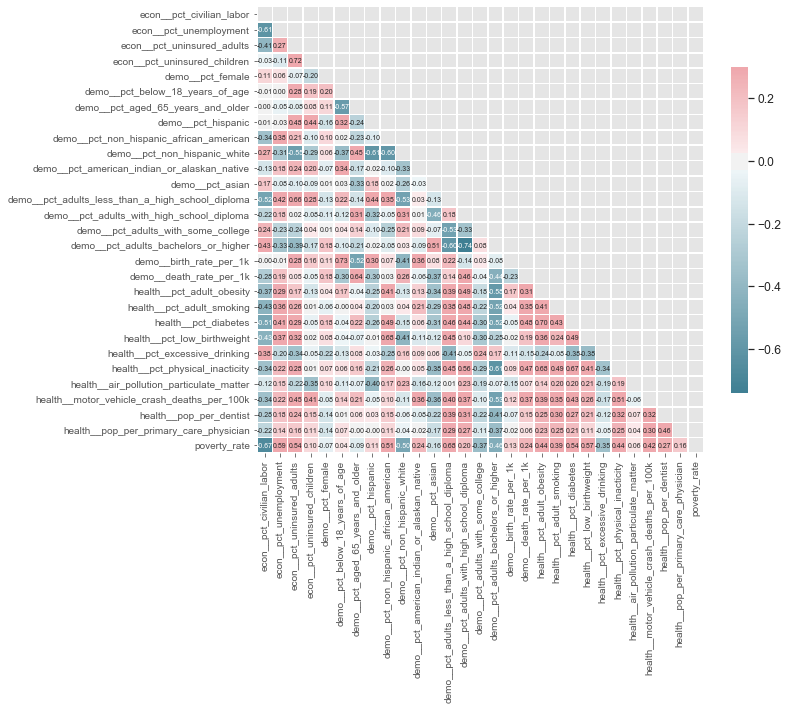

poverty_rate                                        1.000000
demo__pct_adults_less_than_a_high_school_diploma    0.679101
econ__pct_unemployment                              0.591501
health__pct_low_birthweight                         0.565136
econ__pct_uninsured_adults                          0.539475
health__pct_diabetes                                0.535445
demo__pct_non_hispanic_african_american             0.506948
health__pct_adult_obesity                           0.442135
health__pct_physical_inacticity                     0.435457
health__motor_vehicle_crash_deaths_per_100k         0.417716
health__pct_adult_smoking                           0.393624
health__pop_per_dentist                             0.267285
demo__death_rate_per_1k                             0.241755
demo__pct_american_indian_or_alaskan_native         0.236371
demo__pct_adults_with_high_school_diploma           0.199304
health__pop_per_primary_care_physician              0.155098
demo__birth_rate_per_1k 

In [5]:
# --- 5. Explore the data (EDA) --- # 
# Compute summary statistics
df_stat_num = eda_summary_stat_num(clean_train_df)
df_stat_cat = eda_summary_stat_cat(clean_train_df)

# Check 3: handling outliers using IQR #
###############################################################################
# Compute IQR, LB, UB:
df_outliers = outliers_iqr(df_stat_num)

# Correlation matrix plot # 
###########################
df_CM = drop_column_by_index(clean_train_df, cat_vars)
corr = df_CM.corr()
# Create a mask to filter matrix: diagonally
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# CM Plot:
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.set(font_scale=1.1)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            annot=True, square=True, linewidths=.5, fmt=".2f",
            annot_kws={'size':7}, cbar_kws={"shrink": .6})
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Compute the correlation of each feature against poverty rate: order of magnitude
CM_summary = df_CM.corr().sort_values(by=['poverty_rate'], ascending=False)['poverty_rate']
print(CM_summary)

#### Feature Encoding ####
Feature encoding is a process where feature are encoded into right format. There are two types of feature encoding: ordinal and nominal feature encoding. Ordinal feature encoding is a type of encoding where feature actually contains information about "order" like increase or decrease in value (i.e., score level, date, etc). Whereas nominal feature encoding is a type of encoding where feature contains a class of label like gender (i.e., male or female).

**Ordinal feature encoding:** area_rucc and area_urban_influence. 
area_rucc is a feature where it has an order classified by population size of counties by degree of urbanization. Thus, area_rucc gets mapped into numerical values. Same goes for area_urban_influence where it has a natural order by size of counties and proximity to metro and micropolitan areas. For checking format of data consistency, we will print transformed features.

In [6]:
# --- 6. Feature encode on categorical variables --- #
# Define manual mapping for area__rucc:
urban_deg_map ={'Nonmetro - Completely rural or less than 2,500 urban population, not adjacent to a metro area': 1,
        'Nonmetro - Completely rural or less than 2,500 urban population, adjacent to a metro area': 1,
        'Nonmetro - Urban population of 2,500 to 19,999, not adjacent to a metro area': 2,
        'Nonmetro - Urban population of 2,500 to 19,999, adjacent to a metro area': 2,
        'Nonmetro - Urban population of 20,000 or more, not adjacent to a metro area': 3,
        'Nonmetro - Urban population of 20,000 or more, adjacent to a metro area': 3,
        'Metro - Counties in metro areas of fewer than 250,000 population': 4,
        'Metro - Counties in metro areas of 250,000 to 1 million population': 5,
        'Metro - Counties in metro areas of 1 million population or more': 6}

# Define manual mapping for area__urban_influence:
urban_size_map ={'Noncore adjacent to a small metro and does not contain a town of at least 2,500 residents': 1,
               'Noncore adjacent to a small metro with town of at least 2,500 residents': 2,
               'Noncore not adjacent to a metro/micro area and does not contain a town of at least 2,500 residents': 3,
               'Noncore not adjacent to a metro/micro area and contains a town of 2,500  or more residents': 4,
               'Noncore adjacent to micro area and contains a town of 2,500-19,999 residents': 5,
               'Noncore adjacent to a large metro area': 6,
               'Micropolitan not adjacent to a metro area': 7,
               'Micropolitan adjacent to a small metro area': 8,
               'Micropolitan adjacent to a large metro area': 9,
               'Small-in a metro area with fewer than 1 million residents': 10,
               'Large-in a metro area with at least 1 million residents or more': 11}

# Define manual mapping for yr:
yr_map ={'a':'year 1', 'b':'year 2'}

# Use deg_urban_map to transform the area__rucc into ordinal integers:
clean_train_df['area__rucc'] = encode_ordinal_feature(clean_train_df,'area__rucc',urban_deg_map)
clean_test_df['area__rucc'] = encode_ordinal_feature(clean_test_df,'area__rucc',urban_deg_map)

# Use deg_urban_map to transform the area__rucc into ordinal integers:
clean_train_df['area__urban_influence'] = encode_ordinal_feature(clean_train_df,'area__urban_influence',urban_size_map)
clean_test_df['area__urban_influence'] = encode_ordinal_feature(clean_test_df,'area__urban_influence',urban_size_map)

# User yr_map to transform yr feature into ordinal strings:
clean_train_df['yr'] = encode_ordinal_feature(clean_train_df,'yr',yr_map)
clean_test_df['yr'] = encode_ordinal_feature(clean_test_df,'yr',yr_map)

#del (urban_deg_map, urban_size_map, yr_map)

clean_train_df.isnull().sum()
clean_test_df.isnull().sum()

0    5
1    2
2    2
3    3
4    1
Name: area__rucc, dtype: int64
0    2
1    5
2    6
3    1
4    1
Name: area__rucc, dtype: int64
0    10.0
1     5.0
2     6.0
3     9.0
4     1.0
Name: area__urban_influence, dtype: float64
0     2.0
1    10.0
2    11.0
3     7.0
4     6.0
Name: area__urban_influence, dtype: float64
0    year 1
1    year 2
2    year 1
3    year 1
4    year 1
Name: yr, dtype: object
0    year 2
1    year 2
2    year 2
3    year 1
4    year 2
Name: yr, dtype: object


area__rucc                                            0
area__urban_influence                               168
econ__economic_typology                               0
econ__pct_civilian_labor                              0
econ__pct_unemployment                                0
econ__pct_uninsured_adults                            8
econ__pct_uninsured_children                          8
demo__pct_female                                      8
demo__pct_below_18_years_of_age                       8
demo__pct_aged_65_years_and_older                     8
demo__pct_hispanic                                    8
demo__pct_non_hispanic_african_american               8
demo__pct_non_hispanic_white                          8
demo__pct_american_indian_or_alaskan_native           8
demo__pct_asian                                       8
demo__pct_adults_less_than_a_high_school_diploma      0
demo__pct_adults_with_high_school_diploma             0
demo__pct_adults_with_some_college              

####  Feature Imputation ####
Let's compute feature imputation to replace missing values by following:
* Mode: area__urban_influence
* Mean: health_pct_adult_smoking, excessive_drinking, ... ,health_pct_air_pollution (idx: 5-14, 21-28)
* Median: health_pop_dentist and health_pop_primary_care_physician will be replaced (idx: 29, 30)

**Note:** how different types of features were treated by different univariate methods for missing value replacement. 
* First, 'area__urban_influence' was a ordinal (categorical) feature. Thus, it makes sense to replace missing values by most frequently occurred value (mode). 
* Second, 'health_pct_adult_smoking', 'excessive_drinking', etc. were numerical features. Also these features showed normal distributions upon plotting histograms. Thus, these can be replaced by mean. 
* Finally, 'health_pop_dentist' and 'health_pop_primary_care_physician' were numerical features but they showed non-normal distributions (i.e., skewed). Thus, it was better to replace them by median instead of mean.

In [7]:
# --- 7. Feature imputation via univariate techniques --- #    
# Split data into input features and target variable #
X_train, y_train = split_dataframe(clean_train_df)
X_test, y_test = split_dataframe(clean_test_df)

# check input features and target variable: train and test sets
print(X_train.head(), X_train.tail())
print(y_train.head(), y_train.tail())

print(X_test.head(), X_test.tail())
print(y_test.head(), y_test.tail())

# Imputation by mode, mean and median: train and test sets
# column index: 1, 5-14, 21-28, 29-30
indices_0 = range(1,2)
indices_1 = range(5,15)
indices_2 = range(21,29)
indices_3 = range(29,31)

X_train.iloc[:, indices_0] = feature_imputer(X_train, 'NaN', 'most_frequent', indices_0)
X_train.iloc[:, indices_1] = feature_imputer(X_train, np.nan, 'mean', indices_1)
X_train.iloc[:, indices_2] = feature_imputer(X_train, 'NaN', 'mean', indices_2)
X_train.iloc[:, indices_3] = feature_imputer(X_train, 'NaN', 'median', indices_3)

X_test.iloc[:, indices_0] = feature_imputer(X_test, 'NaN', 'most_frequent', indices_0)
X_test.iloc[:, indices_1] = feature_imputer(X_test, np.nan, 'mean', indices_1)
X_test.iloc[:, indices_2] = feature_imputer(X_test, 'NaN', 'mean', indices_2)
X_test.iloc[:, indices_3] = feature_imputer(X_test, 'NaN', 'median', indices_3)

X_train.isnull().sum()
X_test.isnull().sum()

# concatenated imputed inputs and output label:
imputed_train_df = pd.concat([X_train, y_train], axis=1)
imputed_test_df = pd.concat([X_test, y_test], axis=1)

del (clean_train_df, X_train, y_train)
del (clean_test_df, X_test, y_test)

# check any missing values on imputed df:
print(imputed_train_df.isnull().sum())
print(imputed_test_df.isnull().sum())

# convert data types for correct metadata: train and test sets
imputed_train_df['area__rucc'] = convert_data_type(imputed_train_df, 'area__rucc', 'category')
imputed_train_df['area__urban_influence'] = convert_data_type(imputed_train_df, 'area__urban_influence', 'category')
imputed_train_df['econ__economic_typology'] = convert_data_type(imputed_train_df, 'econ__economic_typology', 'category')
imputed_train_df['yr'] = convert_data_type(imputed_train_df, 'yr', 'category')

imputed_test_df['area__rucc'] = convert_data_type(imputed_test_df, 'area__rucc', 'category')
imputed_test_df['area__urban_influence'] = convert_data_type(imputed_test_df, 'area__urban_influence', 'category')
imputed_test_df['econ__economic_typology'] = convert_data_type(imputed_test_df, 'econ__economic_typology', 'category')
imputed_test_df['yr'] = convert_data_type(imputed_test_df, 'yr', 'category')

# check cleaned dataframe: data types
imputed_train_df.dtypes
imputed_test_df.dtypes

# Save feature_df for EDA portfolio:
df_eda = imputed_train_df.copy()

# Inverse transform back to original categorical variables:
inv_urban_deg_map = {i:j for j, i in urban_deg_map.items()}
inv_urban_size_map= {i:j for j, i in urban_size_map.items()}

df_eda['area__rucc'] = encode_ordinal_feature(df_eda, 'area__rucc', inv_urban_deg_map)
df_eda['area__urban_influence'] = encode_ordinal_feature(df_eda, 'area__urban_influence', inv_urban_size_map)

df_eda.to_csv('df_eda.csv', index=False)

   area__rucc  area__urban_influence  econ__economic_typology  \
0           5                   10.0               Recreation   
1           2                    5.0         Mining-dependent   
2           2                    6.0  Manufacturing-dependent   
3           3                    9.0           Nonspecialized   
4           1                    1.0               Recreation   

   econ__pct_civilian_labor  econ__pct_unemployment  \
0                     0.388                   0.075   
1                     0.642                   0.025   
2                     0.562                   0.048   
3                     0.409                   0.089   
4                     0.567                   0.078   

   econ__pct_uninsured_adults  econ__pct_uninsured_children  demo__pct_female  \
0                       0.238                         0.080             0.510   
1                       0.224                         0.137             0.484   
2                       0.139      

area__rucc                                          0
area__urban_influence                               0
econ__economic_typology                             0
econ__pct_civilian_labor                            0
econ__pct_unemployment                              0
econ__pct_uninsured_adults                          0
econ__pct_uninsured_children                        0
demo__pct_female                                    0
demo__pct_below_18_years_of_age                     0
demo__pct_aged_65_years_and_older                   0
demo__pct_hispanic                                  0
demo__pct_non_hispanic_african_american             0
demo__pct_non_hispanic_white                        0
demo__pct_american_indian_or_alaskan_native         0
demo__pct_asian                                     0
demo__pct_adults_less_than_a_high_school_diploma    0
demo__pct_adults_with_high_school_diploma           0
demo__pct_adults_with_some_college                  0
demo__pct_adults_bachelors_o

C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\yoots\AppData\Local\Continuum\anaconda3\

####  Feature Engineering ####
Using groupby function and computing mean to create a new feature from existing feature(s)

In [8]:
# --- 8. Feature engineering: groupby categorical var ---
# create groupby dataframes:
avg_poverty_by_econ_df = avg_groupby_data(imputed_train_df, 'poverty_rate', 'econ__economic_typology', 'avg_poverty_by_econ_type')
avg_pct_no_diploma_by_econ_df = avg_groupby_data(imputed_train_df, 'demo__pct_adults_less_than_a_high_school_diploma', 'econ__economic_typology', 'avg_pct_no_diploma_by_econ_type')
avg_pct_unemployment_by_econ_df = avg_groupby_data(imputed_train_df, 'econ__pct_unemployment', 'econ__economic_typology', 'avg_pct_unemployment_by_econ_type')

# perform left joins on avg_povety rate, avg_pct_no_diploma, avg_pct_unemployment:
joined_train_df = left_join_data(imputed_train_df, avg_poverty_by_econ_df, key='econ__economic_typology')
joined_train_df = left_join_data(joined_train_df, avg_pct_no_diploma_by_econ_df, key='econ__economic_typology')
joined_train_df = left_join_data(joined_train_df, avg_pct_unemployment_by_econ_df, key='econ__economic_typology')

joined_test_df = left_join_data(imputed_test_df, avg_poverty_by_econ_df, key='econ__economic_typology')
joined_test_df = left_join_data(joined_test_df, avg_pct_no_diploma_by_econ_df, key='econ__economic_typology')
joined_test_df = left_join_data(joined_test_df, avg_pct_unemployment_by_econ_df, key='econ__economic_typology')

del(imputed_train_df, imputed_test_df)
del(avg_poverty_by_econ_df, avg_pct_no_diploma_by_econ_df, avg_pct_unemployment_by_econ_df)

#### One-Hot-Encoding: dummy variable  ####
One-Hot-Encoding on nominal feature allows to create a separate column on each feature and its value are only encoded "0" or "1". This dummy indicator gets interpreted the ML models for making accurate predictions. 

Also to reduce any potential biases of having multi-colinearity, each feature's first encoded dummy variable must be dropped to avoid dummy variable trap (i.e., where independent variables are highly inter-correlated with each other as one predictor can be predicted from other of similar variables: econ_farm_depmendent vs. econ_mining vs. etc.).

In [9]:
# --- 9. One-hot-encode on features --- # 
# Drop first dummy variable to avoid dummy variable trap on each converted feature!
feature_df = one_hot_encode_feature(joined_train_df, cat_vars=cat_vars, num_vars=num_vars)
test_df = one_hot_encode_feature(joined_test_df, cat_vars=cat_vars, num_vars=num_vars)

# List total number of encoded inputs and output:
feature_df.isnull().sum()

# Compute label: poverty_rate
label_df = get_label_df(joined_train_df, 'poverty_rate')

In [10]:
# --- 10. variable inflation factor (VIF) testing --- # 
# perform VIF to deal with multi-colinearity issue
# get variables for computing VIF and add intercept term
X_vif = feature_df.copy()
X_vif['intercept'] = 1

# Compute and view VIF
vif = pd.DataFrame()
vif['variables'] = X_vif.columns
vif['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# View results using print: where VIF is less than 10 (threshold)
print(vif[vif['VIF']<10])

# Create a column list selected by VIF:
vif_col_list = list(vif['variables'][vif['VIF']<10])
vif_col_list.remove('intercept')

vif_df = X_vif[vif_col_list]

del (joined_train_df, joined_test_df)
del (vif, vif_col_list)

C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                                      variables       VIF
0                                  area__rucc_2  4.601467
1                                  area__rucc_3  3.273038
2                                  area__rucc_4  2.995566
3                                  area__rucc_5  3.429570
5                     area__urban_influence_2.0  3.957361
6                     area__urban_influence_3.0  2.264549
7                     area__urban_influence_4.0  2.244659
8                     area__urban_influence_5.0  2.777523
9                     area__urban_influence_6.0  2.268086
10                    area__urban_influence_7.0  3.158245
11                    area__urban_influence_8.0  3.678747
12                    area__urban_influence_9.0  2.417039
13                   area__urban_influence_10.0  7.100028
20                                    yr_year 2  1.172592
21                      demo__birth_rate_per_1k  2.759288
22                      demo__death_rate_per_1k  2.845045
23            

C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [11]:
# --- 11. Feature seleciton: L1 regularization --- # 
# fit L1 to filter out non-zero coefficients
lr_L1 = Lasso(alpha=0.01)
lr_L1.fit(feature_df, label_df)

# Print estimated intercept coefficients:
print('Est. coefficient: {}'.format(lr_L1.intercept_))

# Save L1 feature selection results:
feat_selection_df(feature_df, lr_L1, 'features', 'EstCoef', 'L1_feat_selection_df.xlsx')   

#Create L1 feature selection index:
idx_L1 = np.r_[0,2:7,8:11,12,14,16,18,20:27,28,31:34,35,37,40,45:50]

#Filtered feature_df and test_df
train_L1_df = feature_df[feature_df.columns[idx_L1]]
test_L1_df = test_df[test_df.columns[idx_L1]]

Est. coefficient: 24.46894240599022


In [12]:
# --- 12. Establish a baseline model --- # 
# Establish a baseline model:
#baseline = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2), LinearRegression())
baseline = LinearRegression()
baseline_cv = cross_val_score(baseline, feature_df, label_df, 
                                  cv=5, scoring='neg_mean_squared_error')
baseline_rmse = np.sqrt(-1 * baseline_cv)
baseline_mean_rmse = np.mean(baseline_rmse)
print('Baseline RMSE: ' + str(baseline_mean_rmse))

Baseline RMSE: 3.205451834056639


## Part 3 - DEVELOP ##

In [13]:
# --- 13. Create models --- # 
# initialize model list and dicts
models = []
mean_rmse = {}
cv_std = {}
res = {}

# define common model parameters: num processors and shared model parameters
n_proc = 1
verbose_lv = 5

# create and tune the models that you brainstormed during part 2
###############################################################################        
# Hyper-parameters tuning: RandomForest
rf = RandomForestRegressor()   
n_iter = 10
param_dist_rf = {'n_estimators':sp.randint(10,50), 
                  'max_depth':sp.randint(1,10),
                  'min_samples_split':sp.randint(10,60)}

random_search_rf = model_tuning_param(rf, feature_df, label_df, param_dist_rf, n_iter)    
    
# print the best model parameters: RandomForest    
param_1 = 'n_estimators' 
param_2 = 'max_depth'
param_3 = 'min_samples_split'
    
print_best_params(random_search_rf, param_1, param_2, param_3)
###############################################################################    

# Hyper-parameters tuning: GradientBoosting
gbr = GradientBoostingRegressor()
n_iter = 10
param_dist_gbr = {'n_estimators':sp.randint(10,40), 
                  'max_depth':sp.randint(1,20),
                  'loss':['ls']}

random_search_gbr = model_tuning_param(gbr, feature_df, label_df, param_dist_gbr, n_iter)    
    
# print the best model parameters: GradientBoosting    
param_1 = 'n_estimators' 
param_2 = 'max_depth'
param_3 = 'loss'
    
print_best_params(random_search_gbr, param_1, param_2, param_3)        
###############################################################################    

# Hyper-parameters tuning: XGBoost
xgb = XGBRegressor()   
n_iter = 10
param_dist_xgb = {'n_estimators':sp.randint(10,40), 
                  'max_depth':sp.randint(1,20),
                  'learning_rate':np.random.uniform(0,1,10)}

random_search_xgb = model_tuning_param(xgb, feature_df, label_df, param_dist_xgb, n_iter)    
    
# print the best model parameters: XGBRegressor    
param_1 = 'n_estimators' 
param_2 = 'max_depth'
param_3 = 'learning_rate'
    
print_best_params(random_search_xgb, param_1, param_2, param_3)

Best n_estimators: 32
Best max_depth: 8
Best min_samples_split: 27
Best n_estimators: 24
Best max_depth: 7
Best loss: ls
[21:28:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:28:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:28:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:28:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:28:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:28:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:28:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:28:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:28:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:28:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:28:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:28:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:28:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:28:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:28:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:28:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:28:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:28:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[21:28:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:28:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:28:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best n_estimators: 20
Best max_depth: 11
Best learning_rate: 0.1995643897269379


In [14]:
# --- 14. Cross-validate models --- # 
#do 5-fold cross validation on models and measure MSE
# Model List to train: Order of Model Complexity
lr_L1 = Lasso(alpha=0.01)
lr_L2 = Ridge(alpha=0.01)
rf = RandomForestRegressor(n_estimators=13, n_jobs=n_proc, max_depth=8,
                               min_samples_split=10, verbose=verbose_lv)   
gbr = GradientBoostingRegressor(n_estimators=37, max_depth=5, loss='ls', verbose=verbose_lv)
xgb = XGBRegressor(n_estimators=36, max_depth=6, learning_rate=0.28488288425717634) 

models.extend([lr_L1, lr_L2, rf, gbr, xgb])    

# cross-validate models, using MSE to evaluate and print the summaries
print("begin cross-validation")
for model in models:
    model_train(model, feature_df, label_df, n_proc, mean_rmse, cv_std)
    model_summary(model, mean_rmse, cv_std)

# --- 15. Select the best model with lowest RMSE for your prediction model --- #
model = min(mean_rmse, key=mean_rmse.get)
print('\nBest model with the lowest RMSE:')
print(model)

begin cross-validation

Model:
 Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
Average RMSE:
 3.394556364258645
Std. Dev during CV:
 0.17953508879554755

Model:
 Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
Average RMSE:
 3.2042354188873943
Std. Dev during CV:
 0.1654050660021028
building tree 1 of 13
building tree 2 of 13
building tree 3 of 13
building tree 4 of 13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


building tree 5 of 13
building tree 6 of 13
building tree 7 of 13
building tree 8 of 13
building tree 9 of 13
building tree 10 of 13
building tree 11 of 13
building tree 12 of 13
building tree 13 of 13
building tree 1 of 13


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 13
building tree 3 of 13
building tree 4 of 13
building tree 5 of 13
building tree 6 of 13
building tree 7 of 13
building tree 8 of 13
building tree 9 of 13
building tree 10 of 13
building tree 11 of 13
building tree 12 of 13
building tree 13 of 13
building tree 1 of 13
building tree 2 of 13
building tree 3 of 13
building tree 4 of 13
building tree 5 of 13
building tree 6 of 13
building tree 7 of 13
building tree 8 of 13
building tree 9 of 13


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


building tree 10 of 13
building tree 11 of 13
building tree 12 of 13
building tree 13 of 13
building tree 1 of 13
building tree 2 of 13
building tree 3 of 13
building tree 4 of 13
building tree 5 of 13
building tree 6 of 13


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


building tree 7 of 13
building tree 8 of 13
building tree 9 of 13
building tree 10 of 13
building tree 11 of 13
building tree 12 of 13
building tree 13 of 13
building tree 1 of 13
building tree 2 of 13
building tree 3 of 13


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


building tree 4 of 13
building tree 5 of 13
building tree 6 of 13
building tree 7 of 13
building tree 8 of 13
building tree 9 of 13
building tree 10 of 13
building tree 11 of 13
building tree 12 of 13
building tree 13 of 13


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished



Model:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=13, n_jobs=1,
                      oob_score=False, random_state=None, verbose=5,
                      warm_start=False)
Average RMSE:
 2.94335677242065
Std. Dev during CV:
 0.11384735944096835
      Iter       Train Loss   Remaining Time 
         1          39.3420            0.43s
         2          33.7434            0.42s
         3          29.1781            0.42s
         4          25.3523            0.40s
         5          22.1231            0.38s
         6          19.4941            0.36s
         7          17.3374            0.35s
         8          15.4852            0.34s
         9          13.9258            0.33s
        1

        22           5.4343            0.17s
        23           5.2152            0.16s
        24           5.0282            0.15s
        25           4.8447            0.14s
        26           4.7086            0.13s
        27           4.5456            0.11s
        28           4.4113            0.10s
        29           4.2695            0.09s
        30           4.1311            0.08s
        31           4.0382            0.07s
        32           3.9266            0.06s
        33           3.8210            0.05s
        34           3.7262            0.03s
        35           3.6144            0.02s
        36           3.5593            0.01s
        37           3.4904            0.00s

Model:
 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impur

C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:28:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:28:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:28:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:28:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Model:
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.28488288425717634,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
             n_estimators=36, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)
Average RMSE:
 2.6491271692083664
Std. Dev during CV:
 0.09293678423897851

Best model with the lowest RMSE:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.28488288425717634,
             max_de

[21:28:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


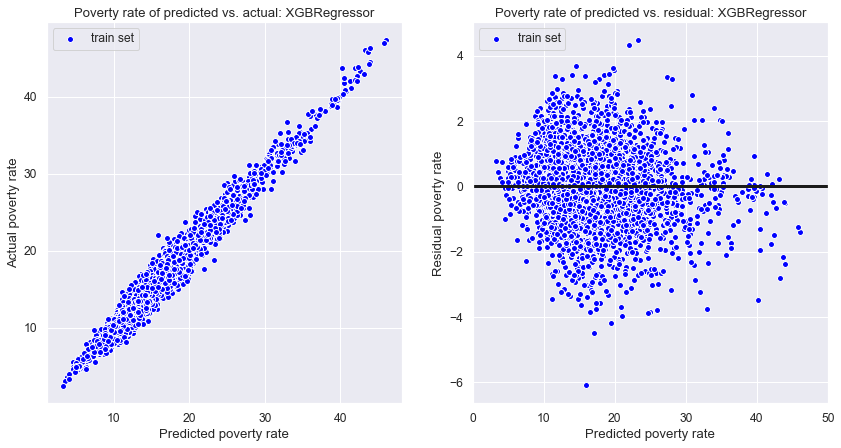

In [15]:
# --- 16. Model Evaluation: Scatter Plot --- #
# Prepare predicted and original poverty rate
y_train_act = label_df.copy()

# re-train a model with best model:
model.fit(feature_df, label_df)
y_train_pred = model.predict(feature_df)
        
# Plot a comparison scatter plot: predicted vs. actual
plt.figure(figsize=(14,7))
plt.subplots_adjust(wspace=0.2)
plt.subplot(1,2,1)
plot_reg_compare(y_train_pred, y_train_act)
plt.title('Poverty rate of predicted vs. actual: XGBRegressor')

# Plot a residual scatter plot: predicted vs. actual
plt.subplot(1,2,2)
plot_reg_residual(y_train_pred, y_train_act)
plt.title('Poverty rate of predicted vs. residual: XGBRegressor')
plt.show()

### Model Evaluation: Comparison and Residual Plots ###
1st figure showed the straight line which indicated how closely predicted and actual poverty rates were plotted.

2nd figure showed the residual poverty rate across the different predicted poverty rates. 

Thus, higher the predicted poverty rates, greater the residual poverty rates (middle range: 15-30). 

### Model Evaluation Summary: Regressor(s) by RMSE ###
Each regression model was carefully evaluated using RMSE. 
Here is a summarized result of all five tested regression models.

#### 1) L1 Lasso Regression: ###
* Avg. RMSE test: 3.39 +/- 0.167

#### 2) L2 Ridge Regression: ###
* Avg. RMSE test: 3.17 +/- 0.167

#### 3) RandomForest Regression: ### 
* Avg. RMSE test: 2.97 +/- 0.204

#### 4) GradientBoosting Regression: ###
* Avg. RMSE test: 2.71 +/- 0.164

#### 5) XGBoost Regression: ###
* Avg. RMSE test: 2.67 +/- 0.197

Thus, XGBRegressor model was the best model with the least avg. RMSE value (2.67) on a test set. 

## Part 4 - DEPLOY ##

In [16]:
# --- 17. Automate the model pipeline --- #
# make predictions based on test set
df_pred = model.predict(test_df)
df_pred = pd.DataFrame(df_pred)

# make predictions dataframe:
df_row_id = pd.DataFrame(df_row_id_test)
df_predictions = pd.concat([df_row_id, df_pred], axis=1)
df_predictions.columns = ['row_id','poverty_rate']

del(df_pred, df_row_id, df_row_id_test)

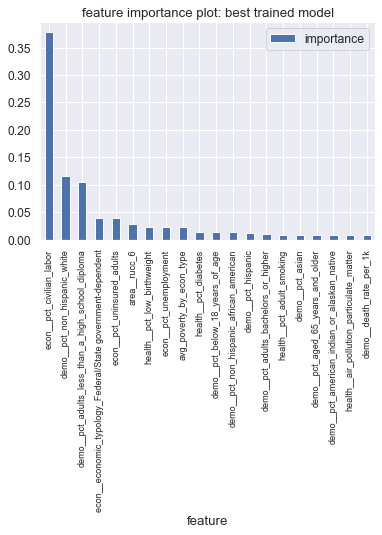

In [17]:
# --- 18. Deploy the solution --- #
#store feature importances
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
else:
#linear models don't have feature_importances
    importances = [0]*len(feature_df.columns)
    
feature_importances = pd.DataFrame({'feature':feature_df.columns, 
                                        'importance':importances})
feature_importances.sort_values(by='importance', ascending=False,
                                    inplace=True)
    
#set index to 'feature'
feature_importances.set_index('feature', inplace=True, drop=True)
    
#create a plot
feature_importances[0:20].plot.bar(align='center')
plt.xticks(rotation=90, fontsize=9)
plt.title('feature importance plot: best trained model')
plt.show()

#Save model results as .csv file:
model_results(model, mean_rmse[model], df_predictions, feature_importances)

### Model Summary: Feature Importance ###
A figure showed the feature importance on the best trained model from order of the highest to lowest feature importance ranks.

Top 5 important features were % civilian labor followed by % adult with no highschool diploma, % non-hispanic white, and % uninsured adults.